In [2]:
#### 1.RNA_seq_data_analysis.R
## The same data used in GSVA analysis
### 1)Loading COAD expression data
# https://xenabrowser.net/datapages/?dataset=TCGA.COAD.sampleMap%2FHiSeqV2&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
# Level_3 data (file names: *.rsem.genes.normalized_results) are downloaded from TCGA DCC, 
# log2(x+1) transformed,and processed at UCSC into Xena repository
TCGA_COAD_RNAseqV2_normalized_log2_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/TCGA_Hub/TCGA_Colon_Cancer_COAD/TCGA_COAD_RNAseqV2_normalized_log2_dataset.rds")
COAD.HiSeqV2.log2 <- TCGA_COAD_RNAseqV2_normalized_log2_dataset$COAD.HiSeqV2.log2
COAD.pheno <- TCGA_COAD_RNAseqV2_normalized_log2_dataset$COAD.pheno
#TCGA_COAD_RNAseqV2_normalized_log2_dataset$COAD.HiSeqV2.metadata # Metadata

### 2)Read cluster resaults
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
hclust.Res <- Cluster.20200201.V7.Tumor$hclust.Res

### 3) Build ExpressionSet object
library(Biobase)
expr.sub <- as.matrix(COAD.HiSeqV2.log2[,colnames(COAD.HiSeqV2.log2) %in% rownames(Cluster.df)])
Cluster.df.sub <- Cluster.df[colnames(expr.sub),1:2]
Cluster.df.sub <- new("AnnotatedDataFrame",
                      data=Cluster.df.sub)
all(rownames(Cluster.df.sub)==colnames(expr.sub))
COAD.ExpressionSet <- ExpressionSet(assayData=expr.sub,phenoData=Cluster.df.sub)


Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory mat

[1] TRUE

Loading required package: limma

Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA



Coefficients not estimable: yellow 


Warning message:
“Partial NA coefficients for 15797 probe(s)”

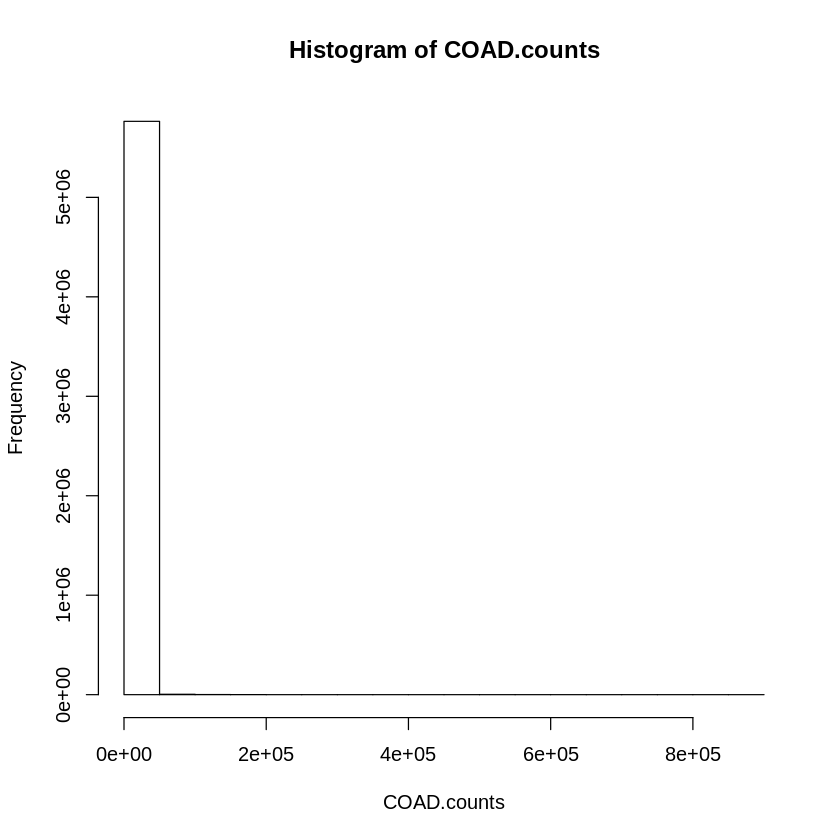

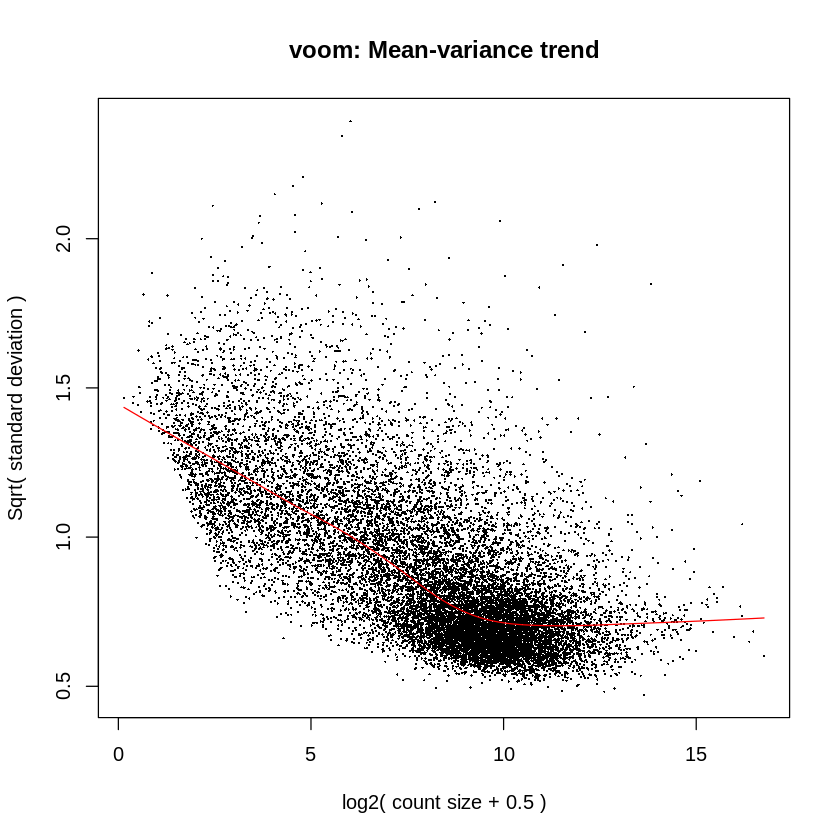

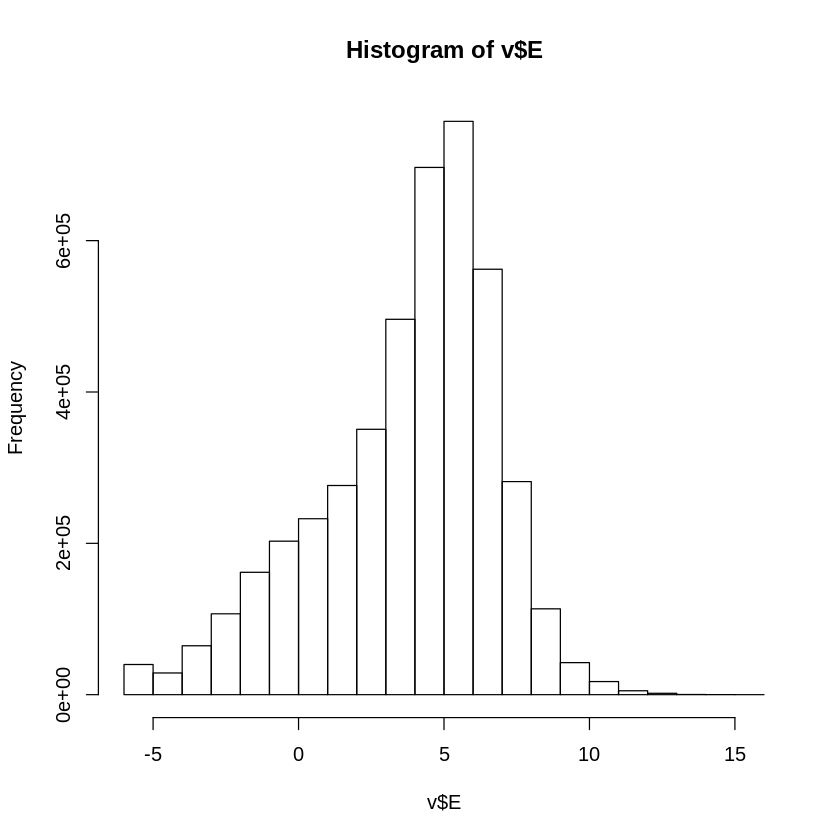

Coefficients not estimable: yellow 


Warning message:
“Partial NA coefficients for 15797 probe(s)”

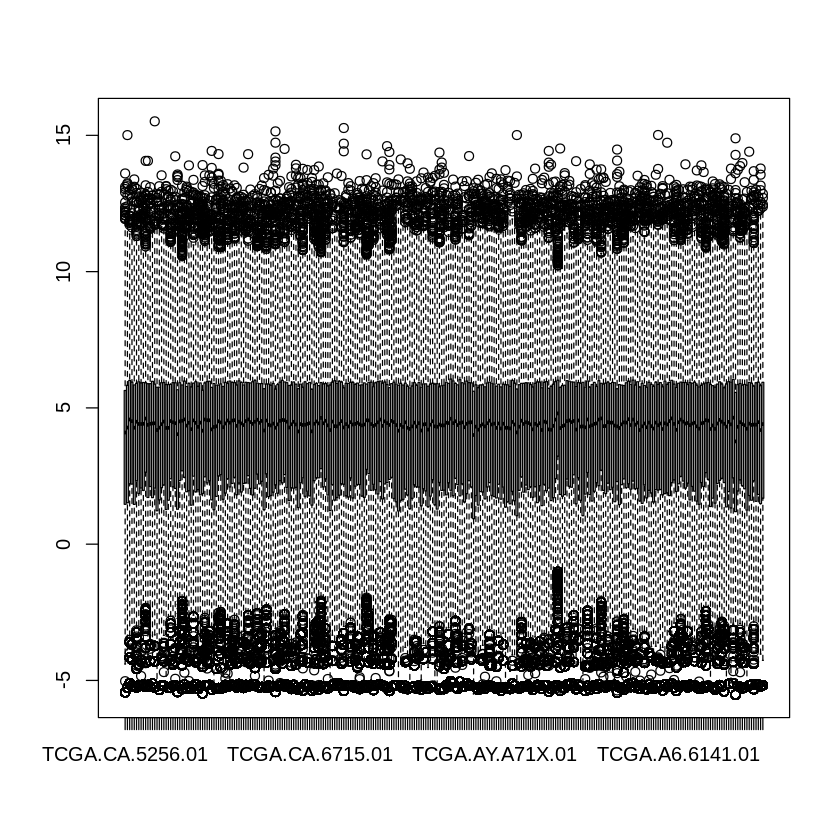

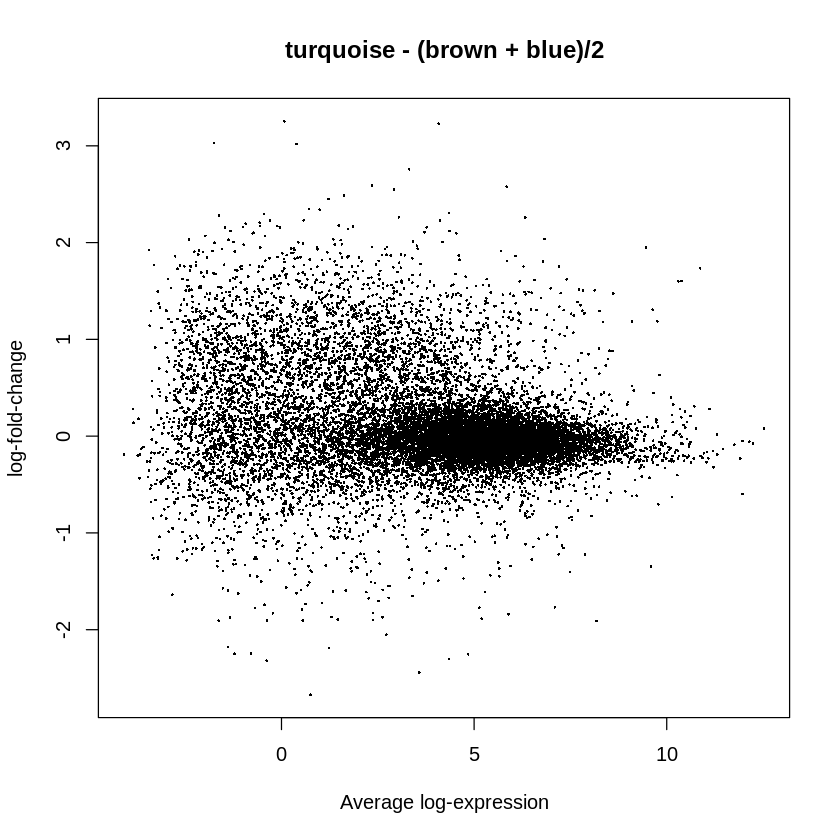

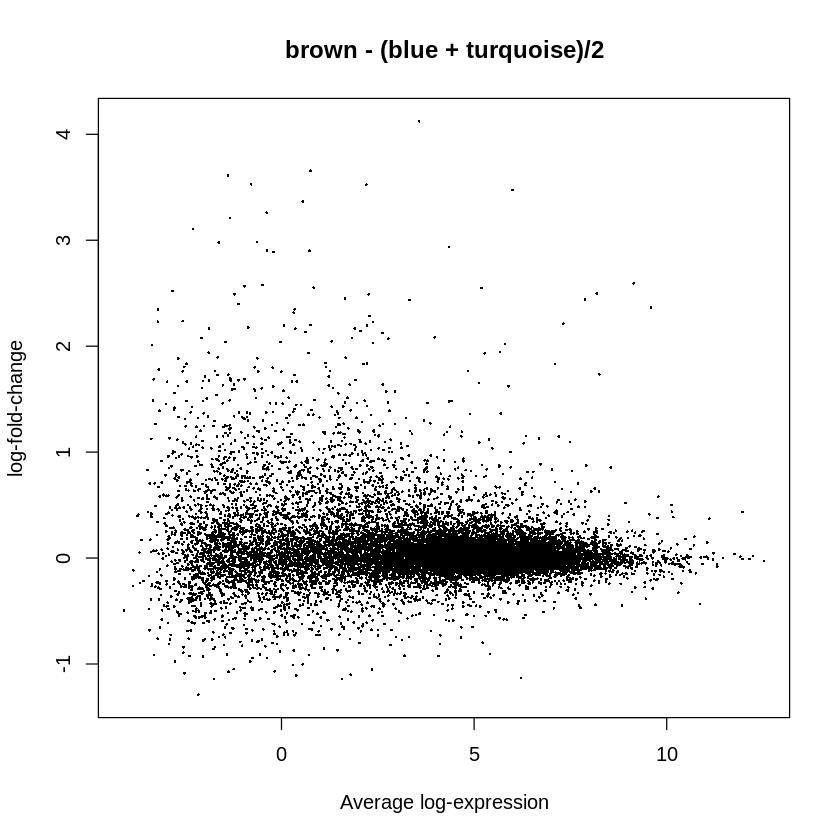

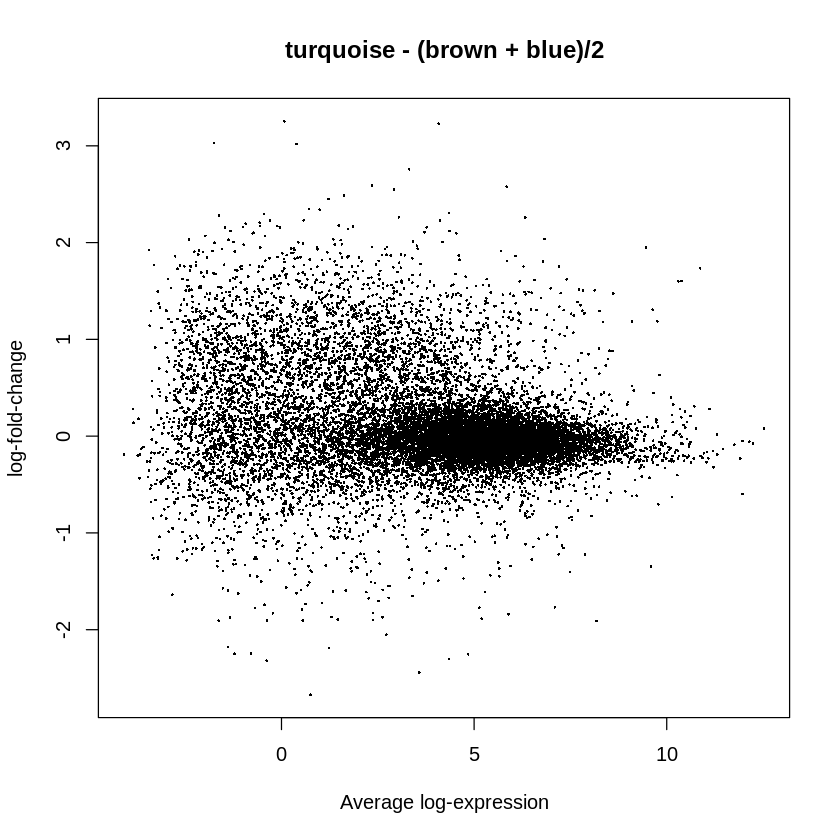

In [3]:
### 4)DEgenes_limma_Voom_methods
## Reverse to counts 
COAD.counts <- 2^exprs(COAD.ExpressionSet) - 1
hist(COAD.counts)
## Several Groups experiment design
#COAD.ExpressionSet@phenoData@data
f.expr <- factor(COAD.ExpressionSet@phenoData@data$dynamicColors, levels=c("blue","brown","turquoise","yellow"))
design.expr <- model.matrix(~0+f.expr)
colnames(design.expr) <- c("blue","brown","turquoise","yellow")
# DGEList object using the edgeR package
library(edgeR)
dge <- DGEList(counts=COAD.counts)
## filter
keep <- filterByExpr(dge, design.expr)
dge <- dge[keep,,keep.lib.sizes=FALSE]
## Voom for RNA-seq data
v <- voom(dge, design.expr,plot=TRUE)
## Normalized Log2 transformed expression data
hist(v$E)
boxplot(v$E)
## 4) limma DE analysis
library(limma)
fit.expr <- lmFit(v, design.expr)
contrast.matrix.expr <- makeContrasts(blue-(brown+turquoise)/2, 
                                      brown-(blue+turquoise)/2,
                                      turquoise-(brown+blue)/2,
                                      levels=design.expr)
fit.expr.2 <- contrasts.fit(fit.expr, contrast.matrix.expr)
fit.expr.2 <- eBayes(fit.expr.2)
plotMD(fit.expr.2)
plotMD(fit.expr.2, column = 2)
plotMD(fit.expr.2, column = 3)

In [4]:
## 6) Set up cutoff for top DE genes
adjPvalueCutoff <- 0.01
logFCcutoff <- log2(2)
## DE genes summary under cutoof above
dt <- decideTests(fit.expr.2,lfc =logFCcutoff, p.value = adjPvalueCutoff )
summary(dt)
number = 100 ## N top genes
DEgenes.blue.v <- topTable(fit.expr.2, coef="blue - (brown + turquoise)/2", number=number,
                           p.value=adjPvalueCutoff,lfc=logFCcutoff,adjust="BH")
DEgenes.brown.v <- topTable(fit.expr.2, coef="brown - (blue + turquoise)/2", number=number,
                            p.value=adjPvalueCutoff,adjust="BH")
DEgenes.turquoise.v <- topTable(fit.expr.2, coef="turquoise - (brown + blue)/2", number=number,
                                p.value=adjPvalueCutoff,adjust="BH")


       blue - (brown + turquoise)/2 brown - (blue + turquoise)/2
Down                           1436                            1
NotSig                        14337                        15484
Up                               24                          312
       turquoise - (brown + blue)/2
Down                            191
NotSig                        14522
Up                             1084

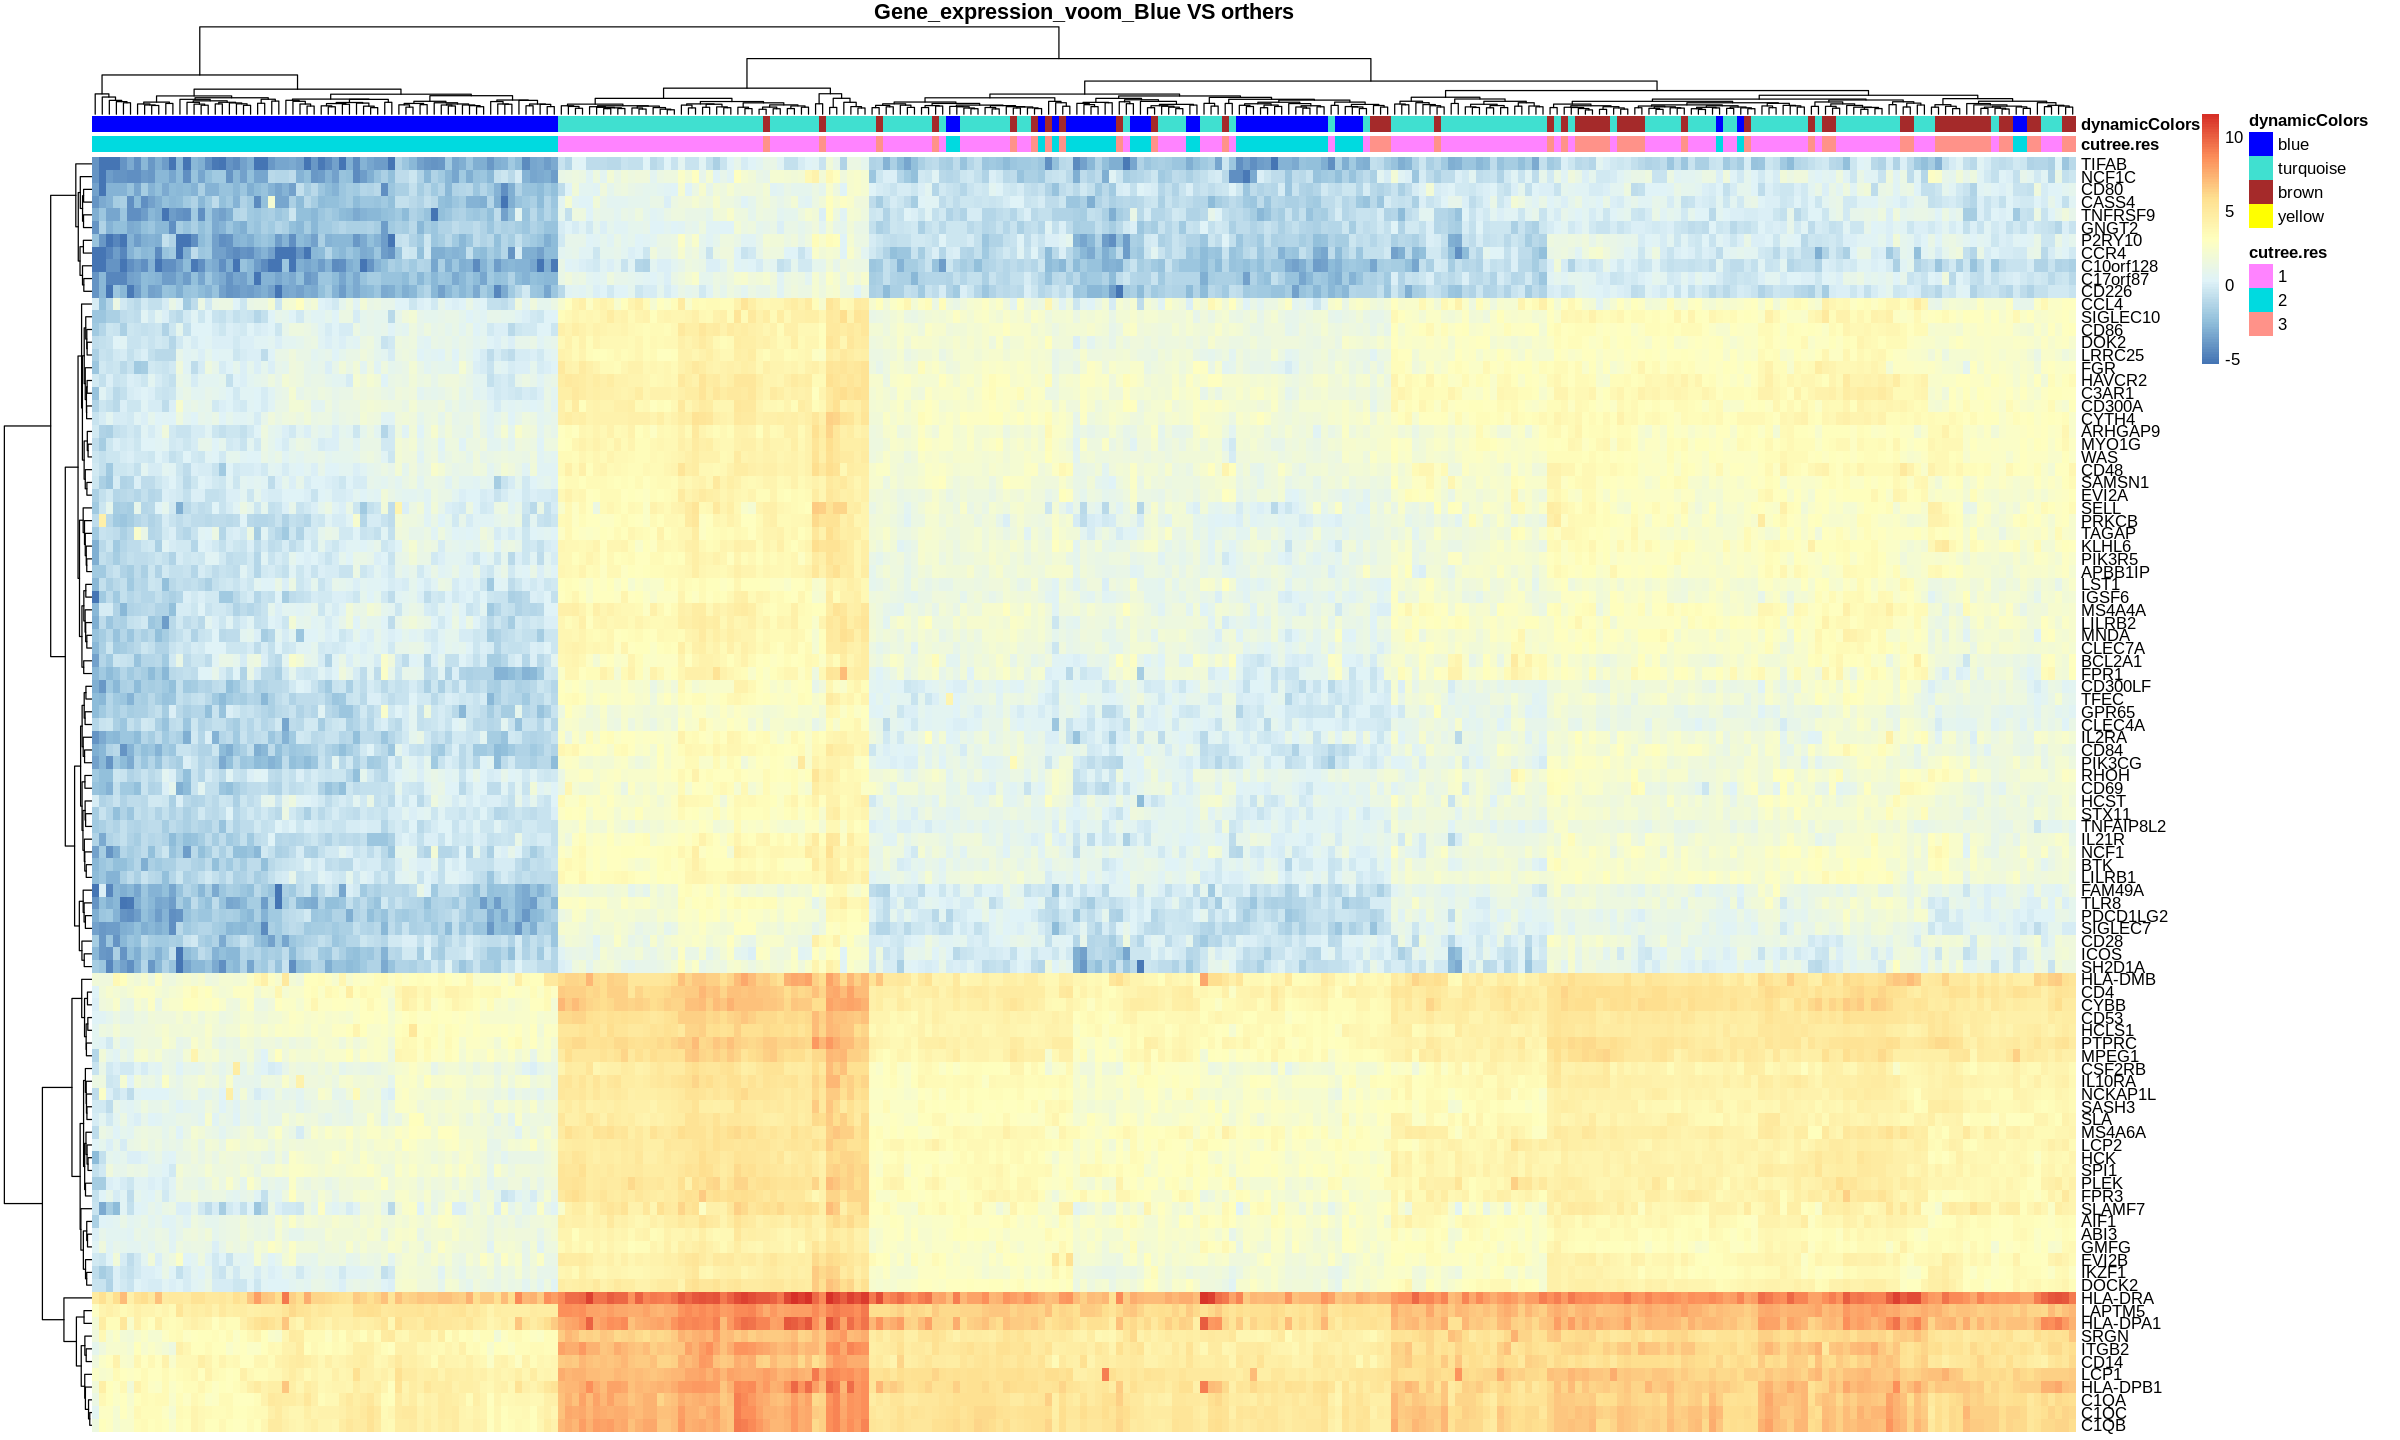

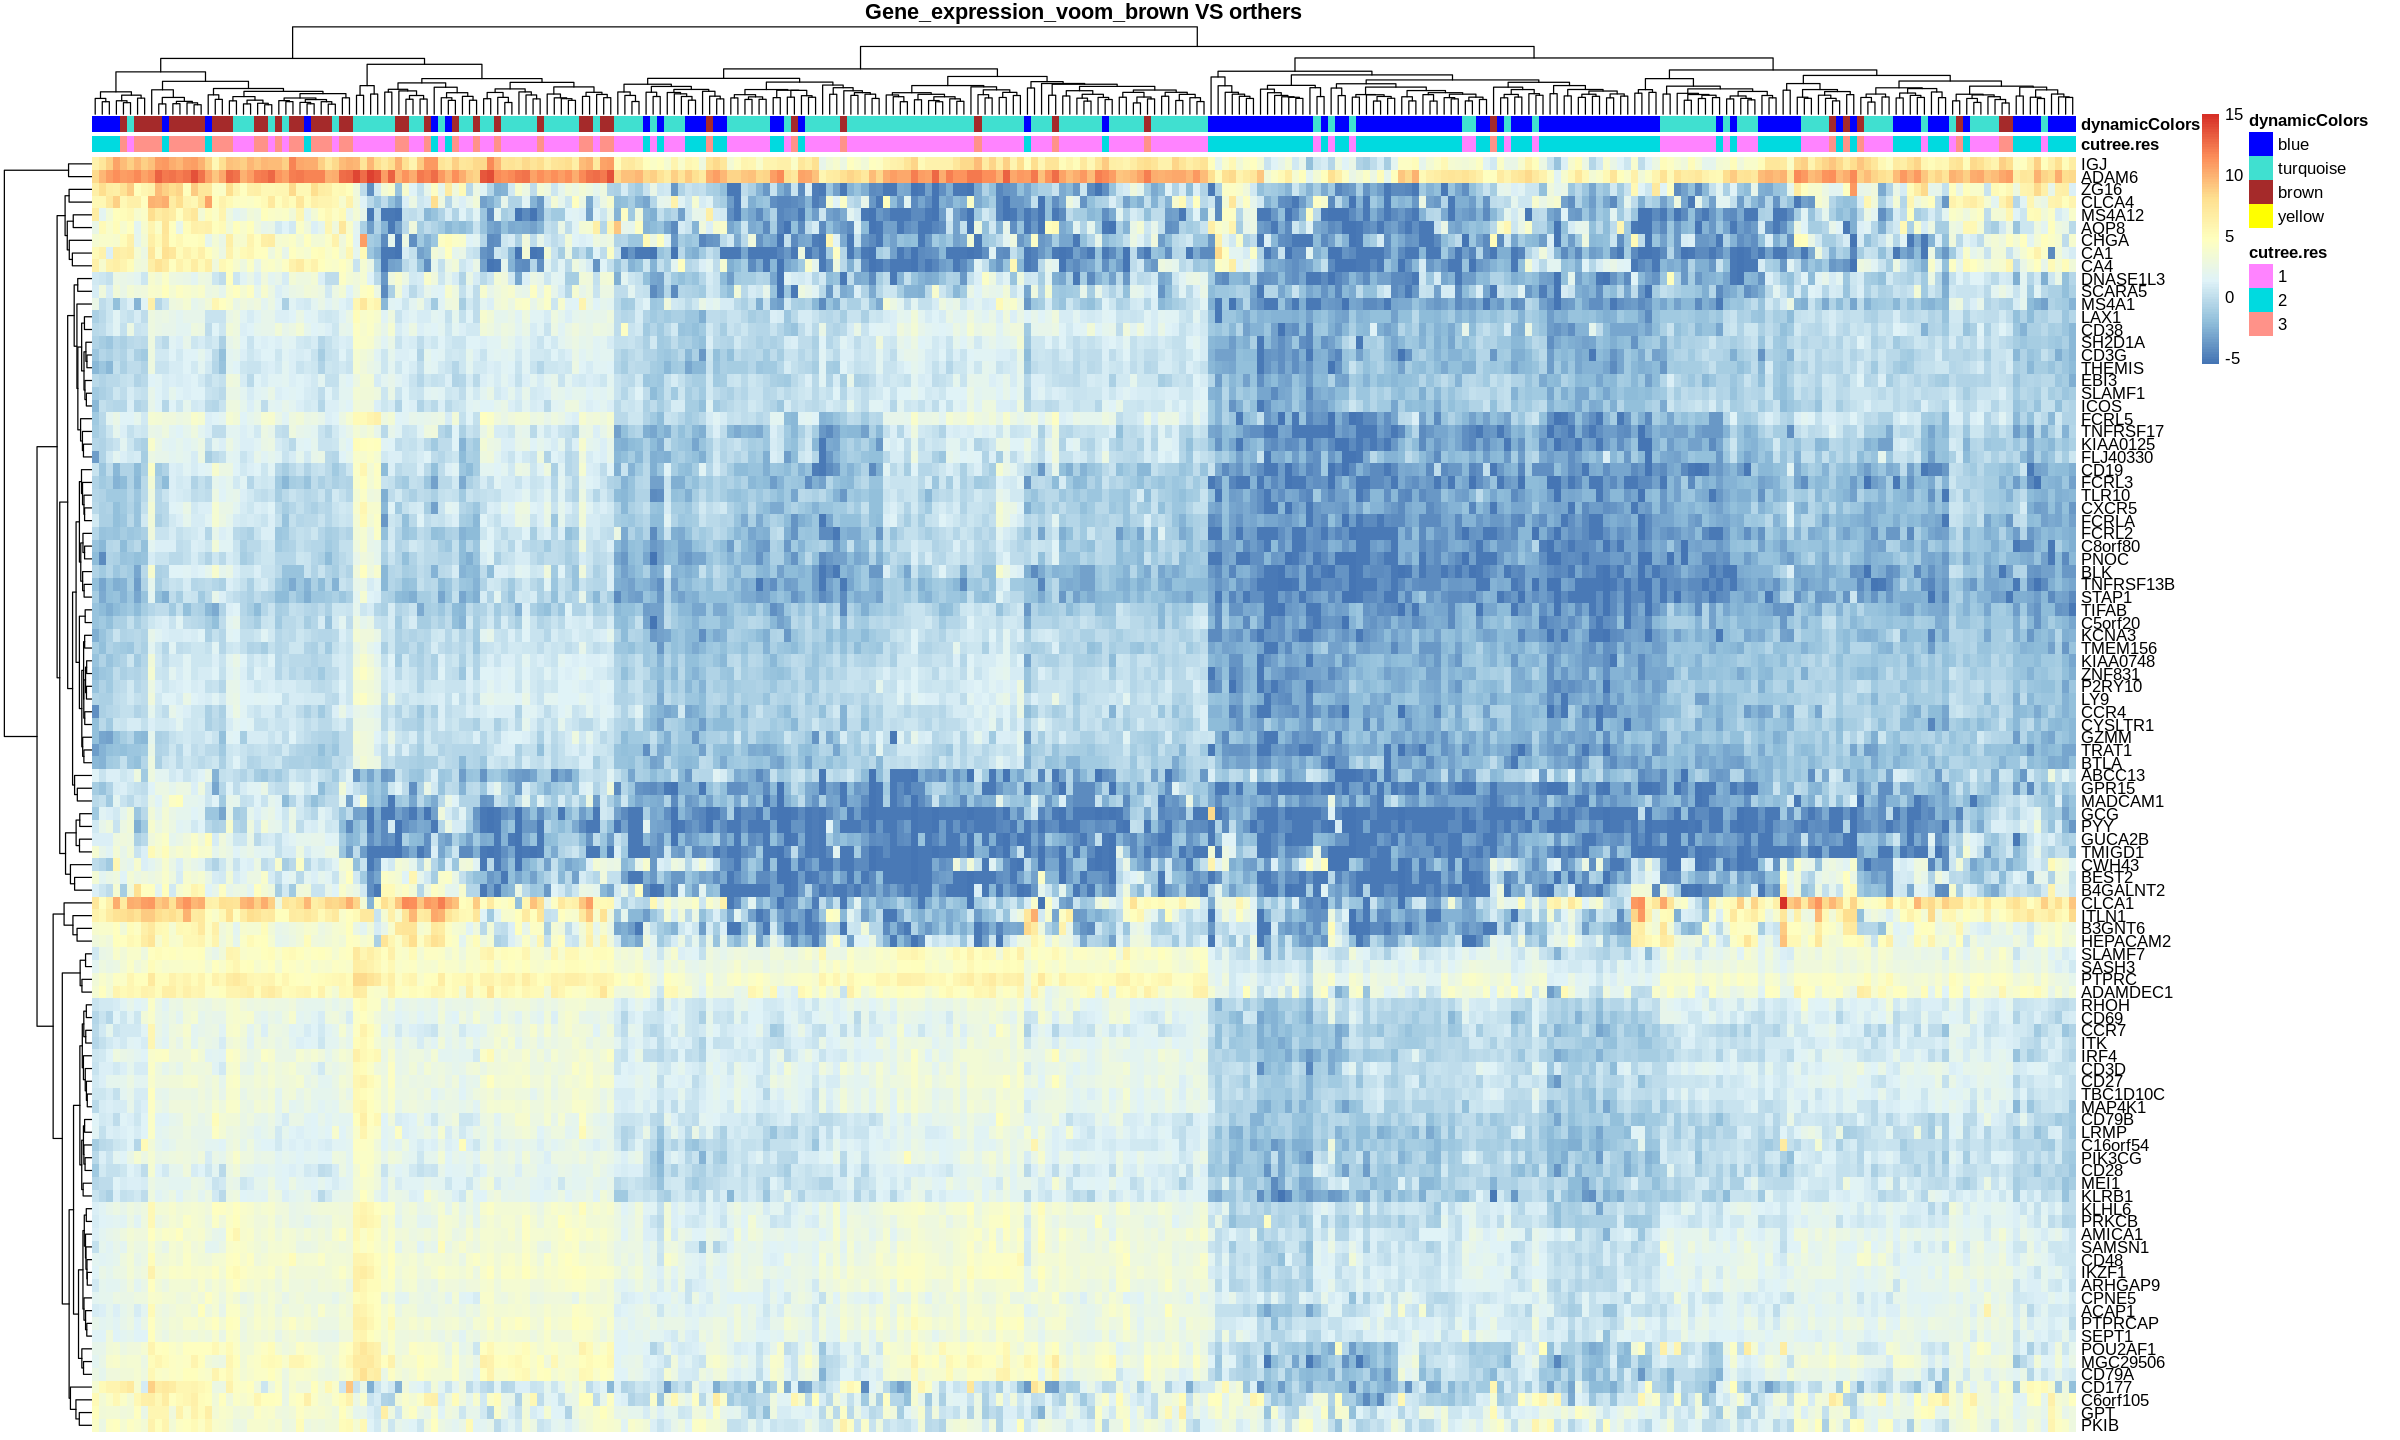

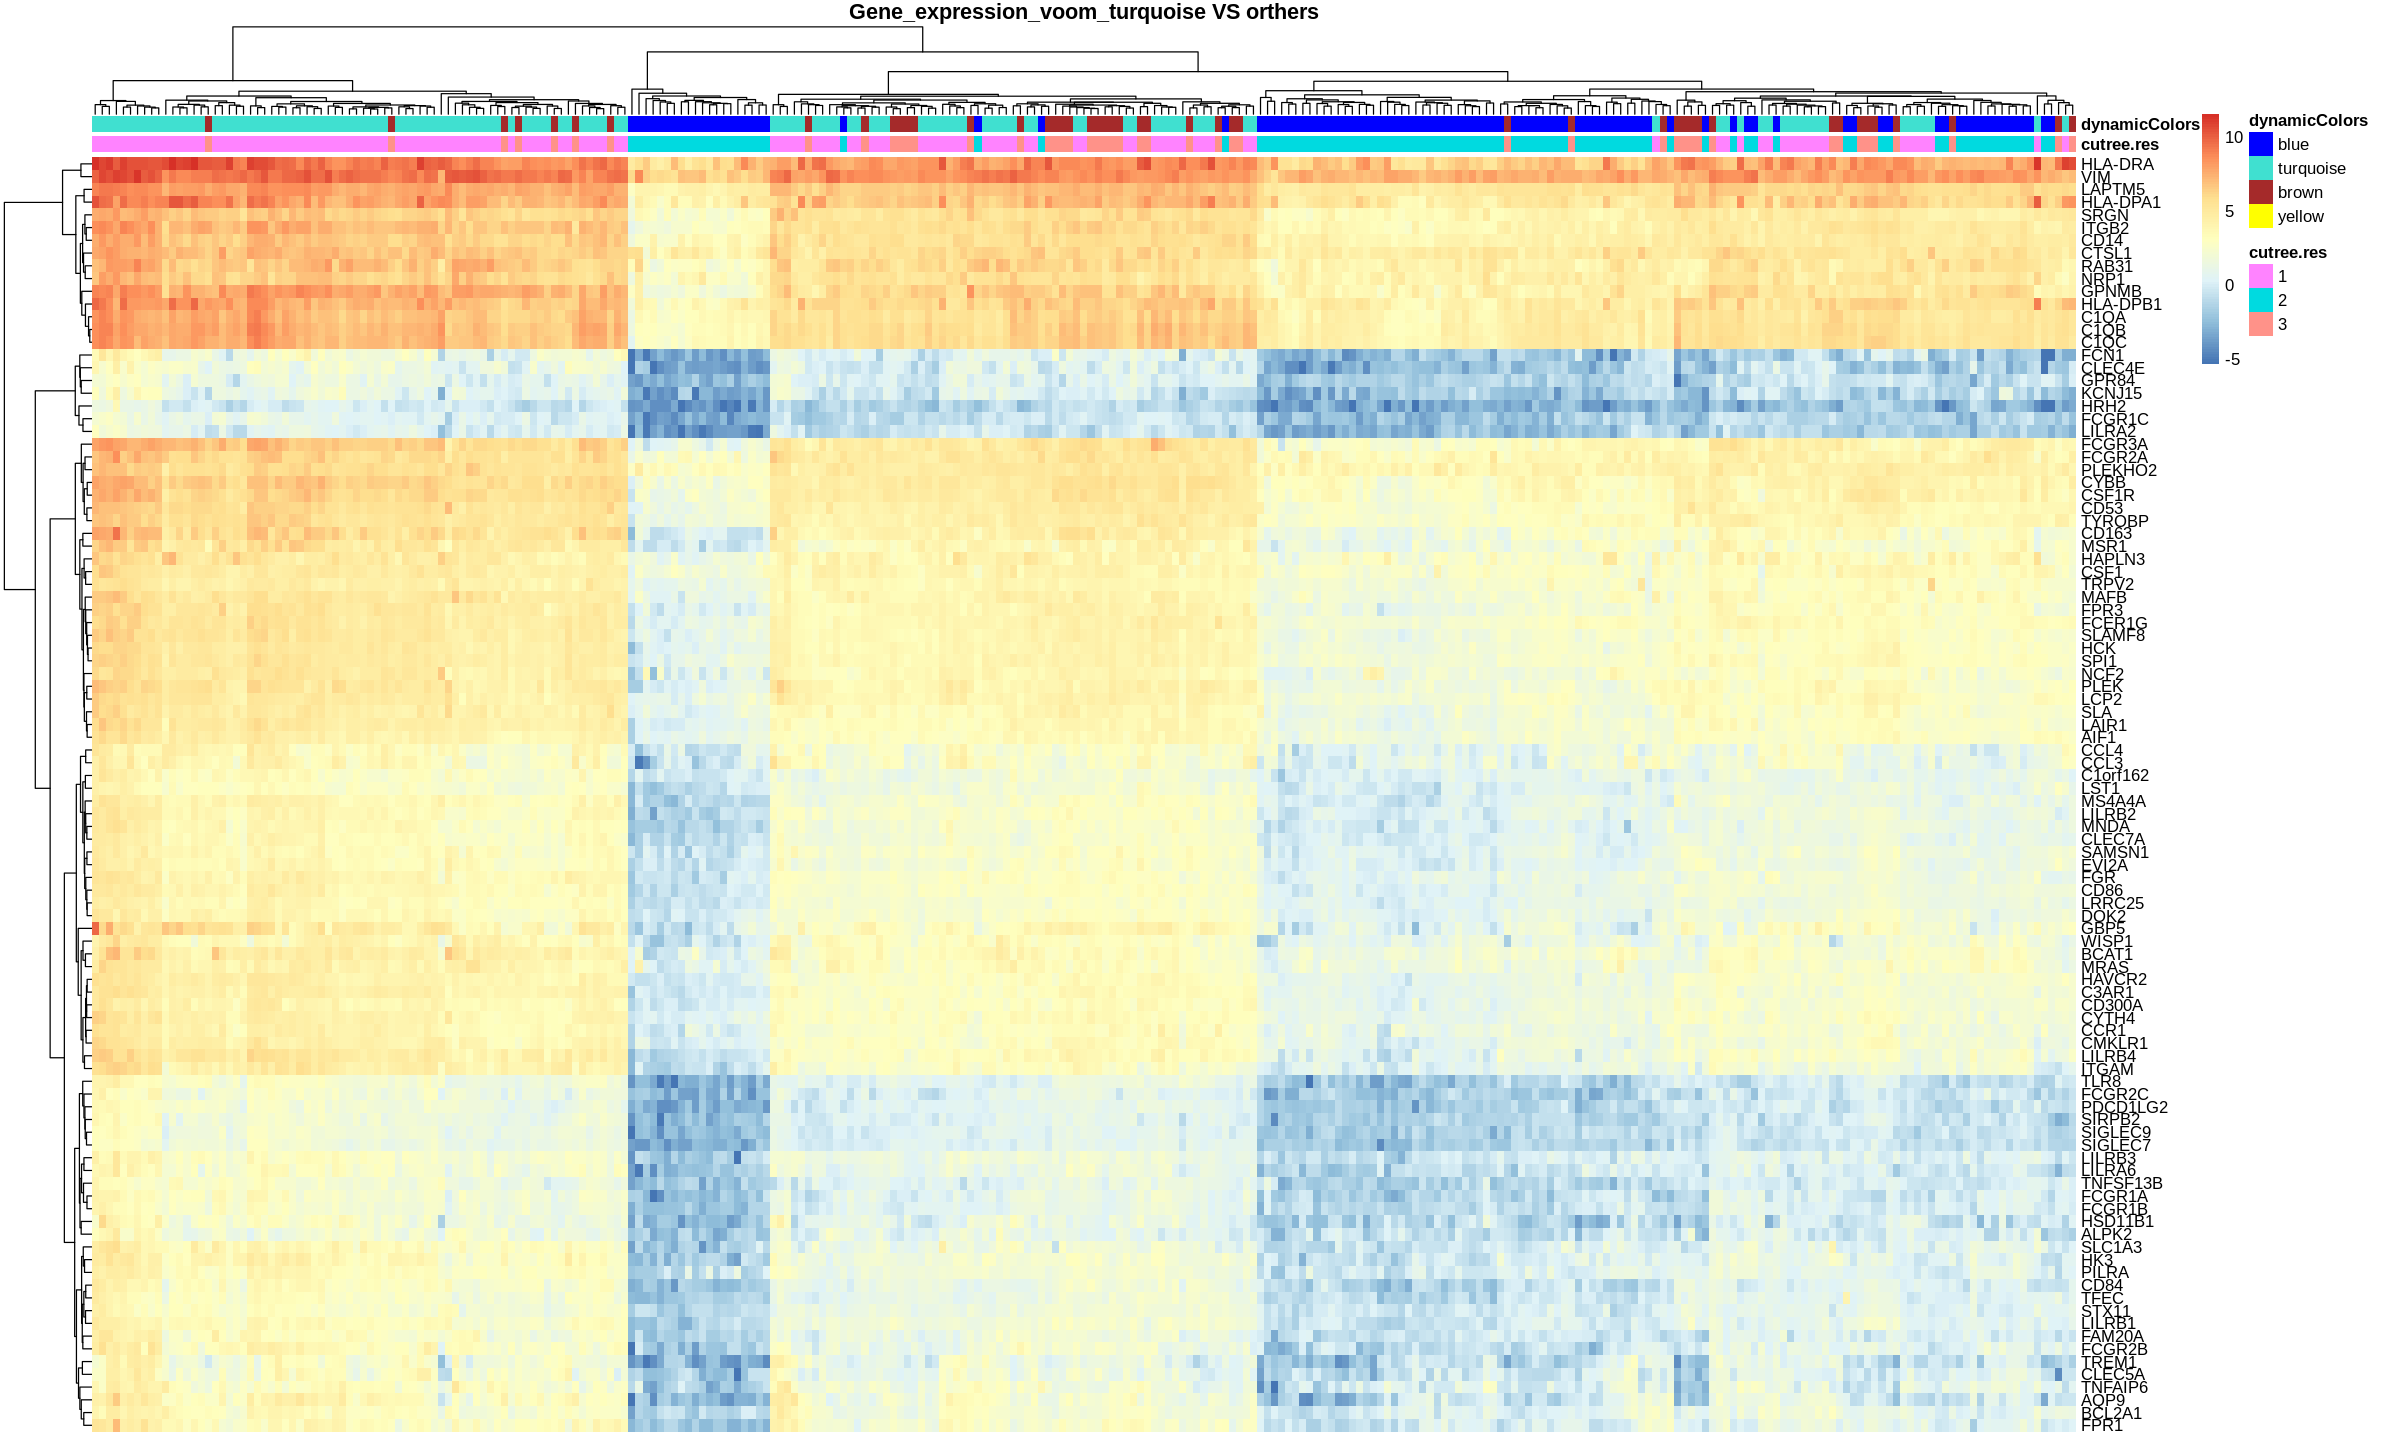

In [7]:
## 7) Heatmap Ploting
options(repr.plot.width=20, repr.plot.height=12)
ann_colors = list(dynamicColors = c(blue = "blue",turquoise = "turquoise", 
                                    brown = "brown", yellow = "yellow"))
pheatmap::pheatmap(v$E[rownames(DEgenes.blue.v),],annotation_col = pData(COAD.ExpressionSet),show_colnames = F,
                   main = "Gene_expression_voom_Blue VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(v$E[rownames(DEgenes.brown.v),],annotation_col = pData(COAD.ExpressionSet),show_colnames = F,
                   main = "Gene_expression_voom_brown VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(v$E[rownames(DEgenes.turquoise.v),],annotation_col = pData(COAD.ExpressionSet),show_colnames = F,
                   main = "Gene_expression_voom_turquoise VS orthers",annotation_colors = ann_colors)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.0000 -0.1923  0.3338  0.3094  0.7704  2.0000 

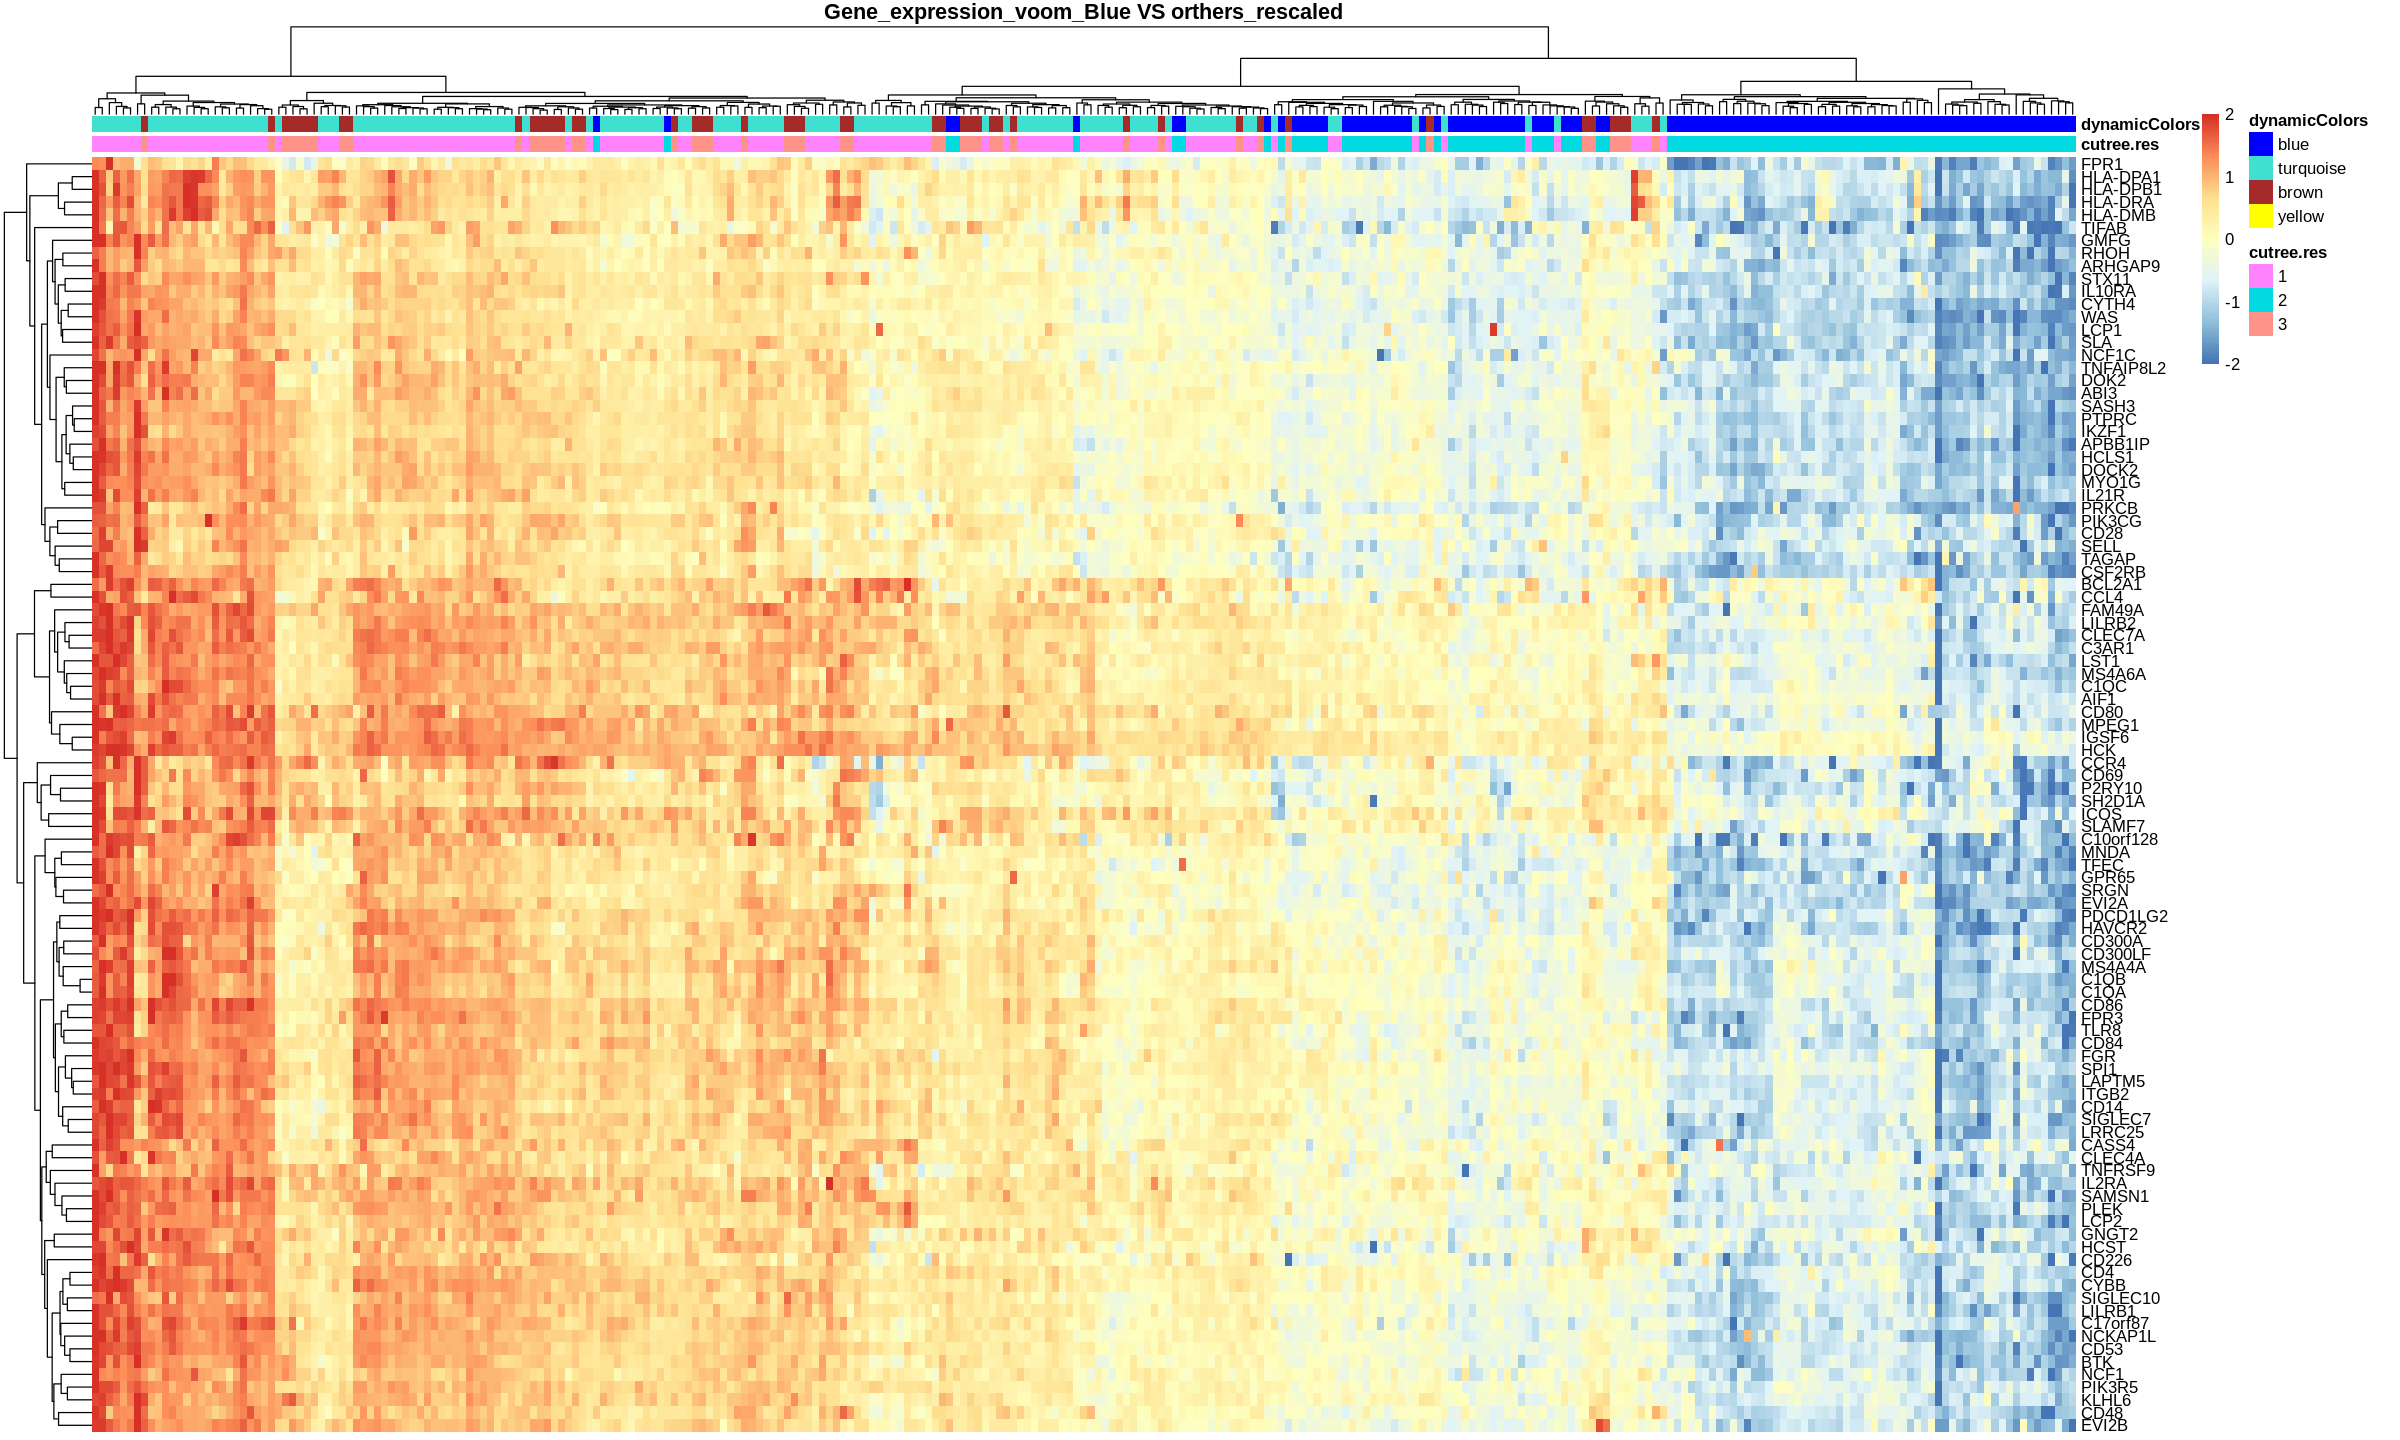

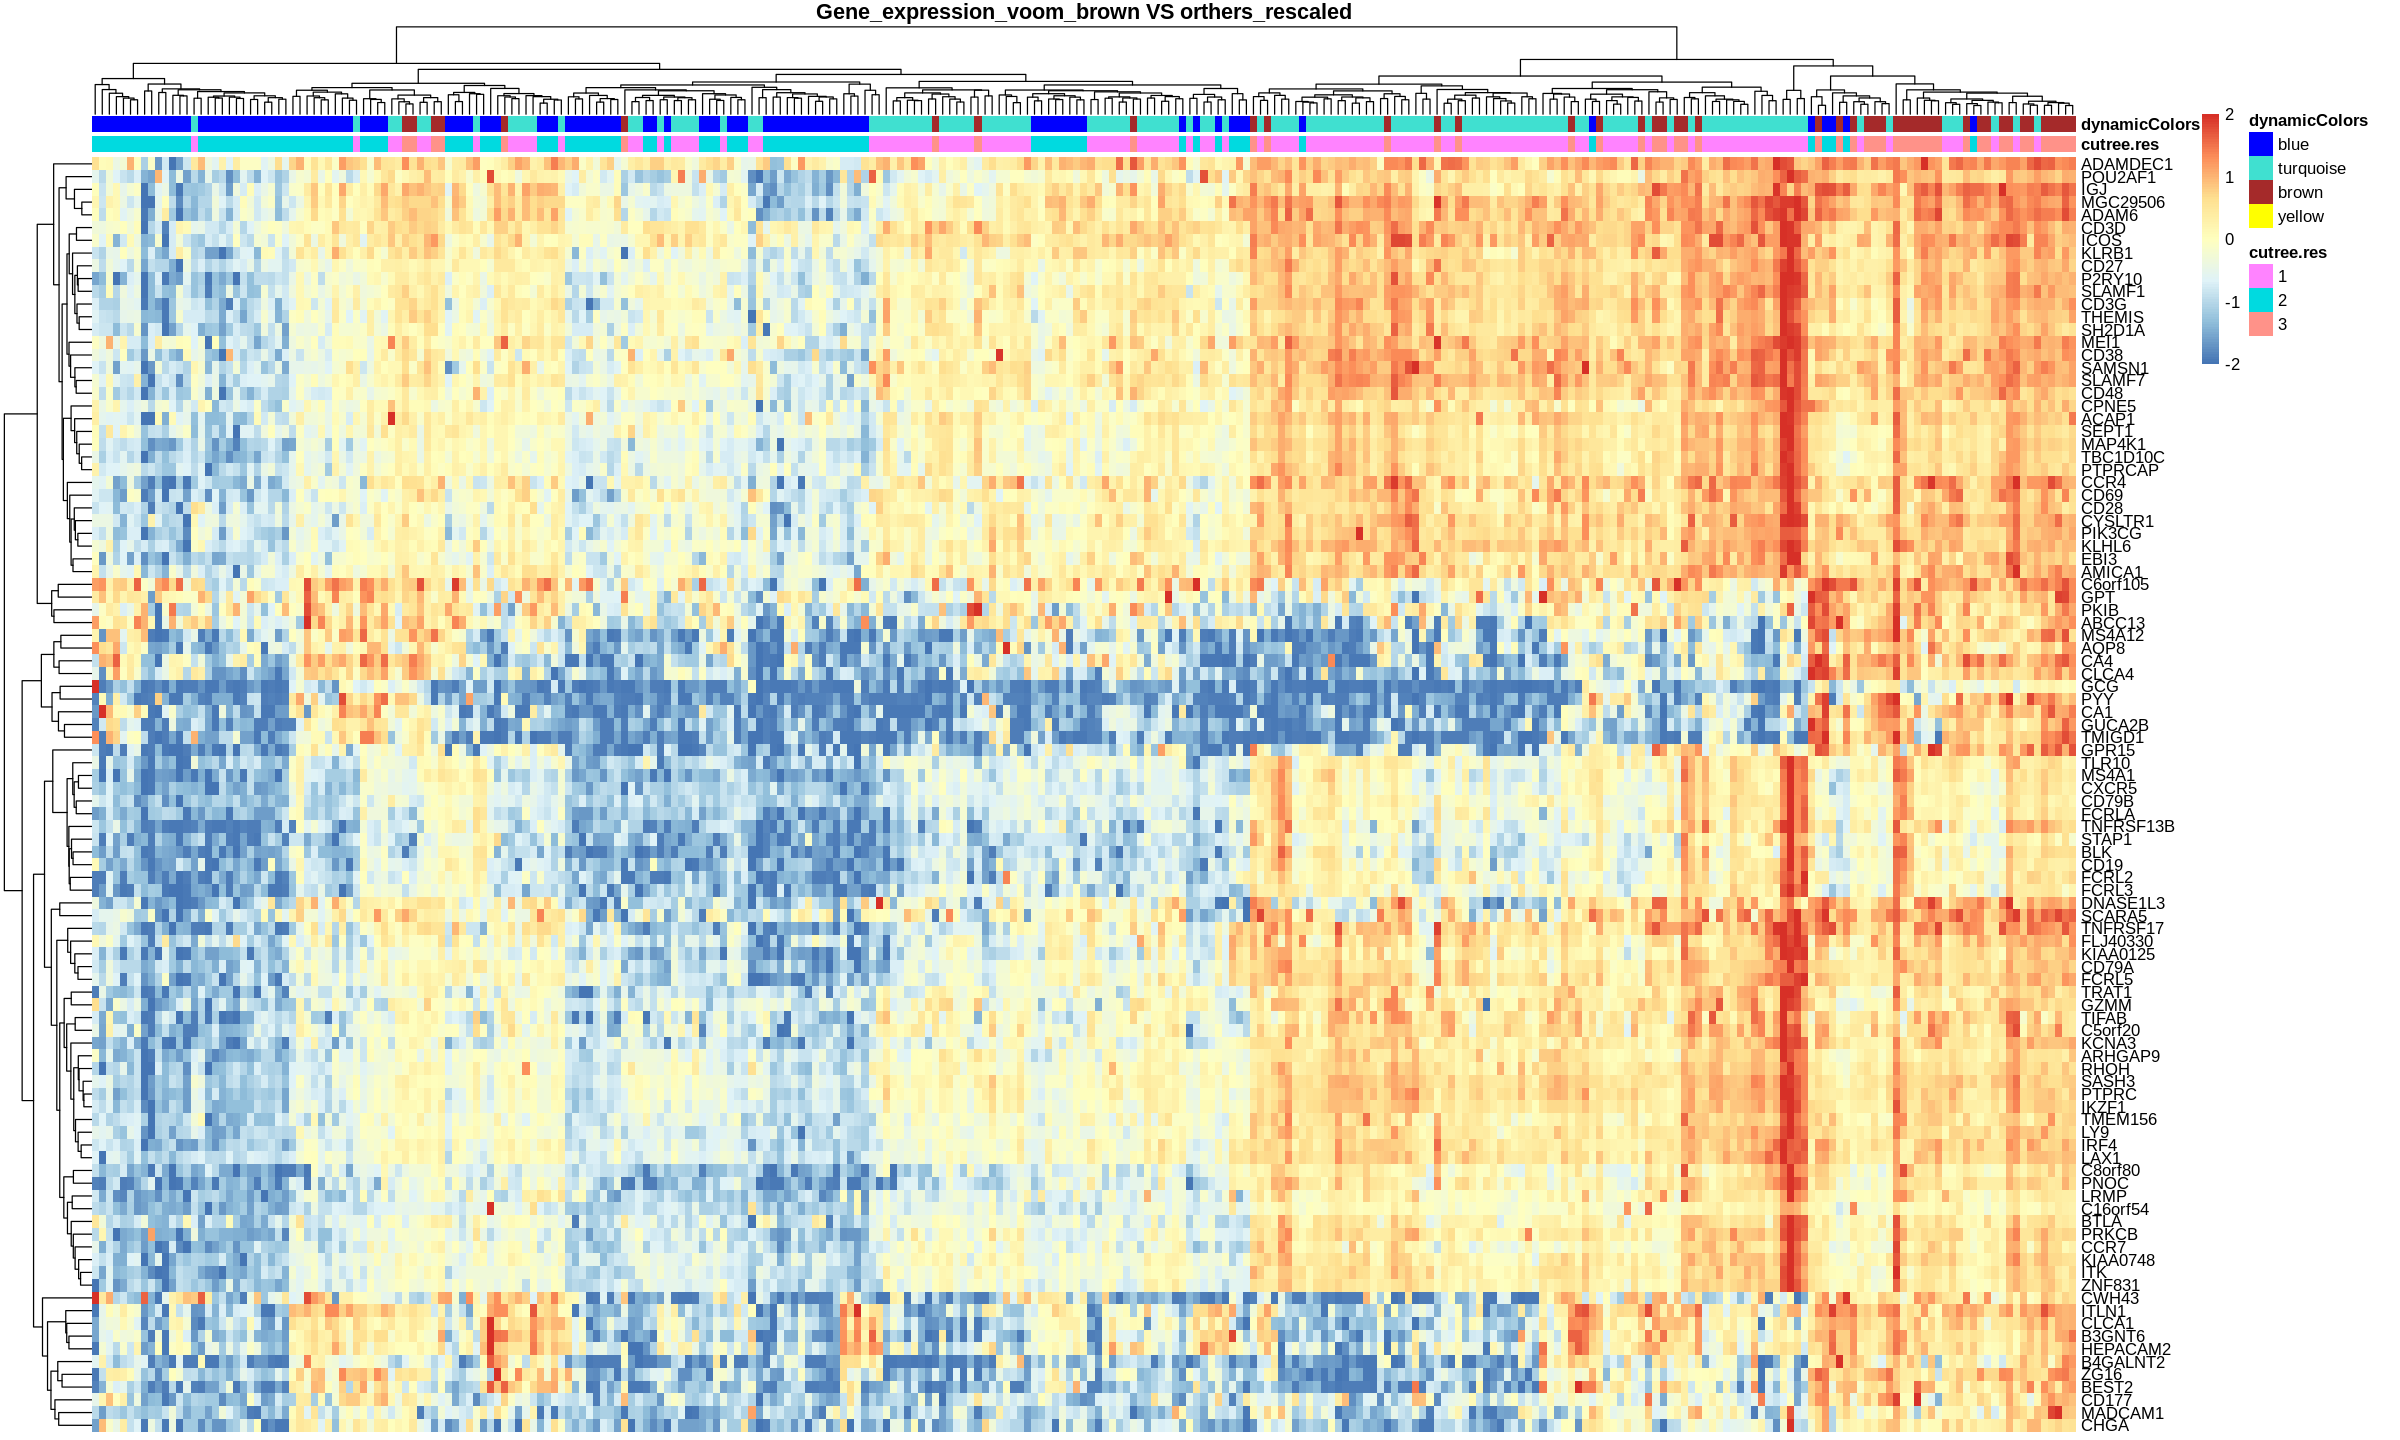

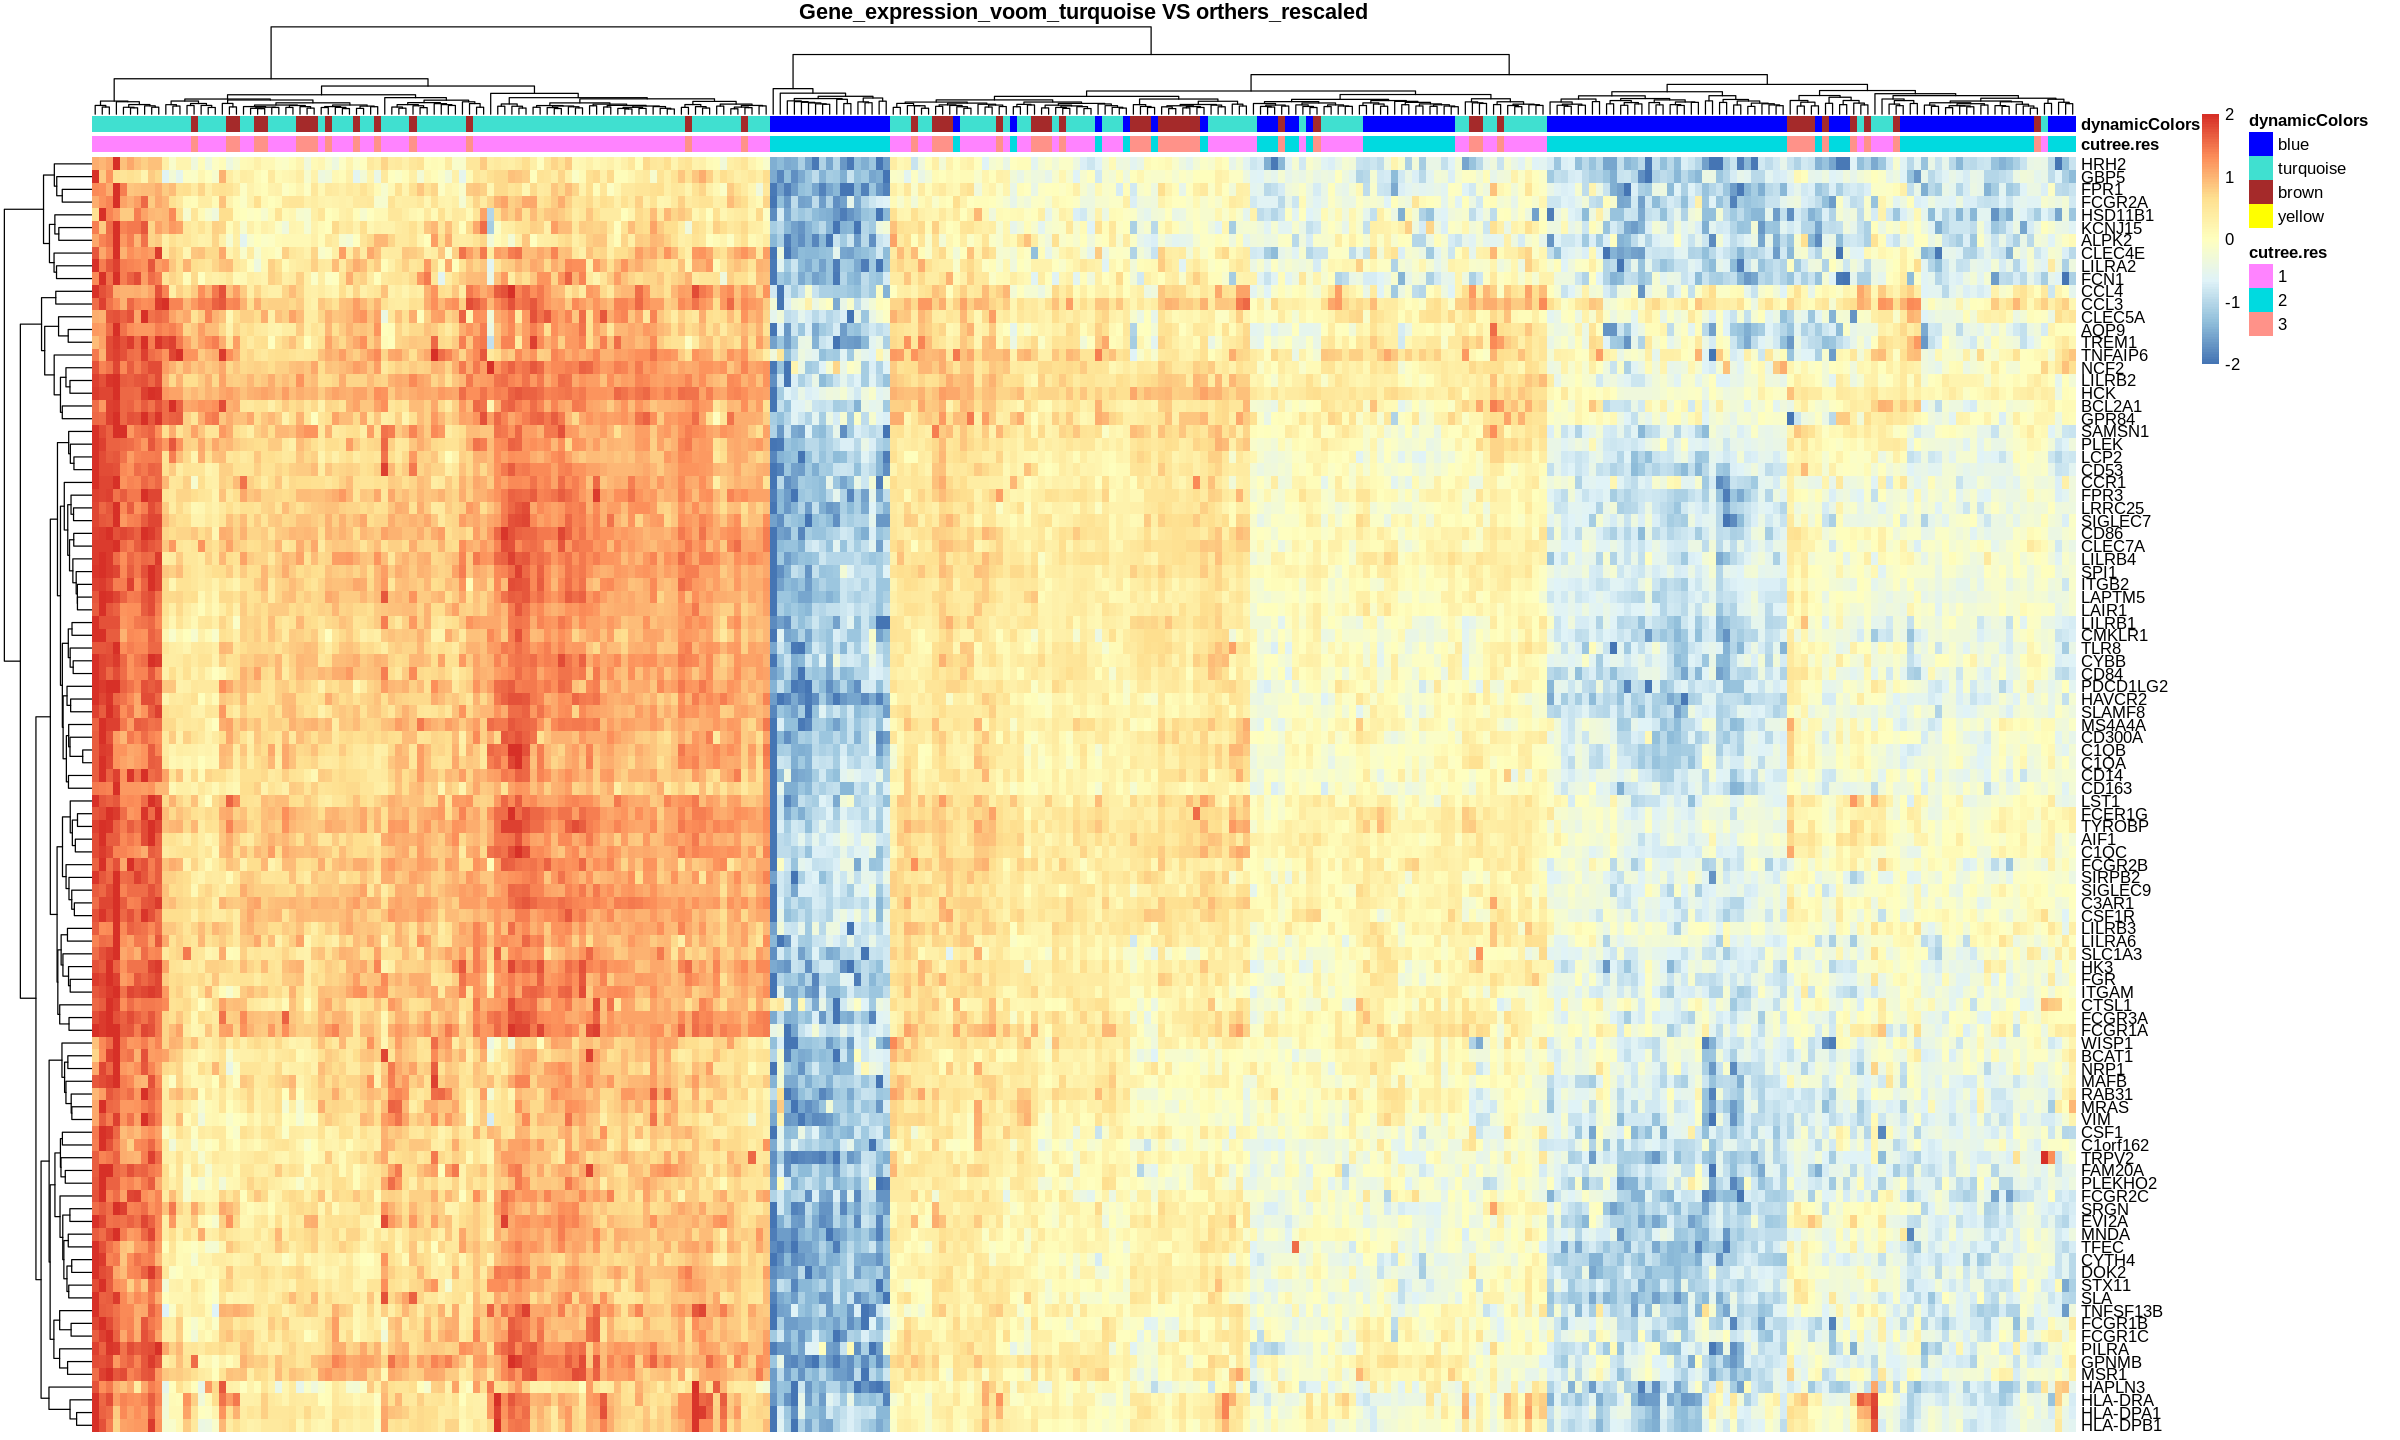

In [8]:
### 8) Ploting rescaled
library(scales)
vE.scaled <- t(apply(v$E, 1, rescale, to=c(-2,2)))
summary(vE.scaled[5,])
options(repr.plot.width=20, repr.plot.height=12)
pheatmap::pheatmap(vE.scaled[rownames(DEgenes.blue.v),],annotation_col = pData(COAD.ExpressionSet),show_colnames = F,
                   main = "Gene_expression_voom_Blue VS orthers_rescaled",annotation_colors = ann_colors)
pheatmap::pheatmap(vE.scaled[rownames(DEgenes.brown.v),],annotation_col = pData(COAD.ExpressionSet),show_colnames = F,
                   main = "Gene_expression_voom_brown VS orthers_rescaled",annotation_colors = ann_colors)
pheatmap::pheatmap(vE.scaled[rownames(DEgenes.turquoise.v),],annotation_col = pData(COAD.ExpressionSet),show_colnames = F,
                   main = "Gene_expression_voom_turquoise VS orthers_rescaled",annotation_colors = ann_colors)




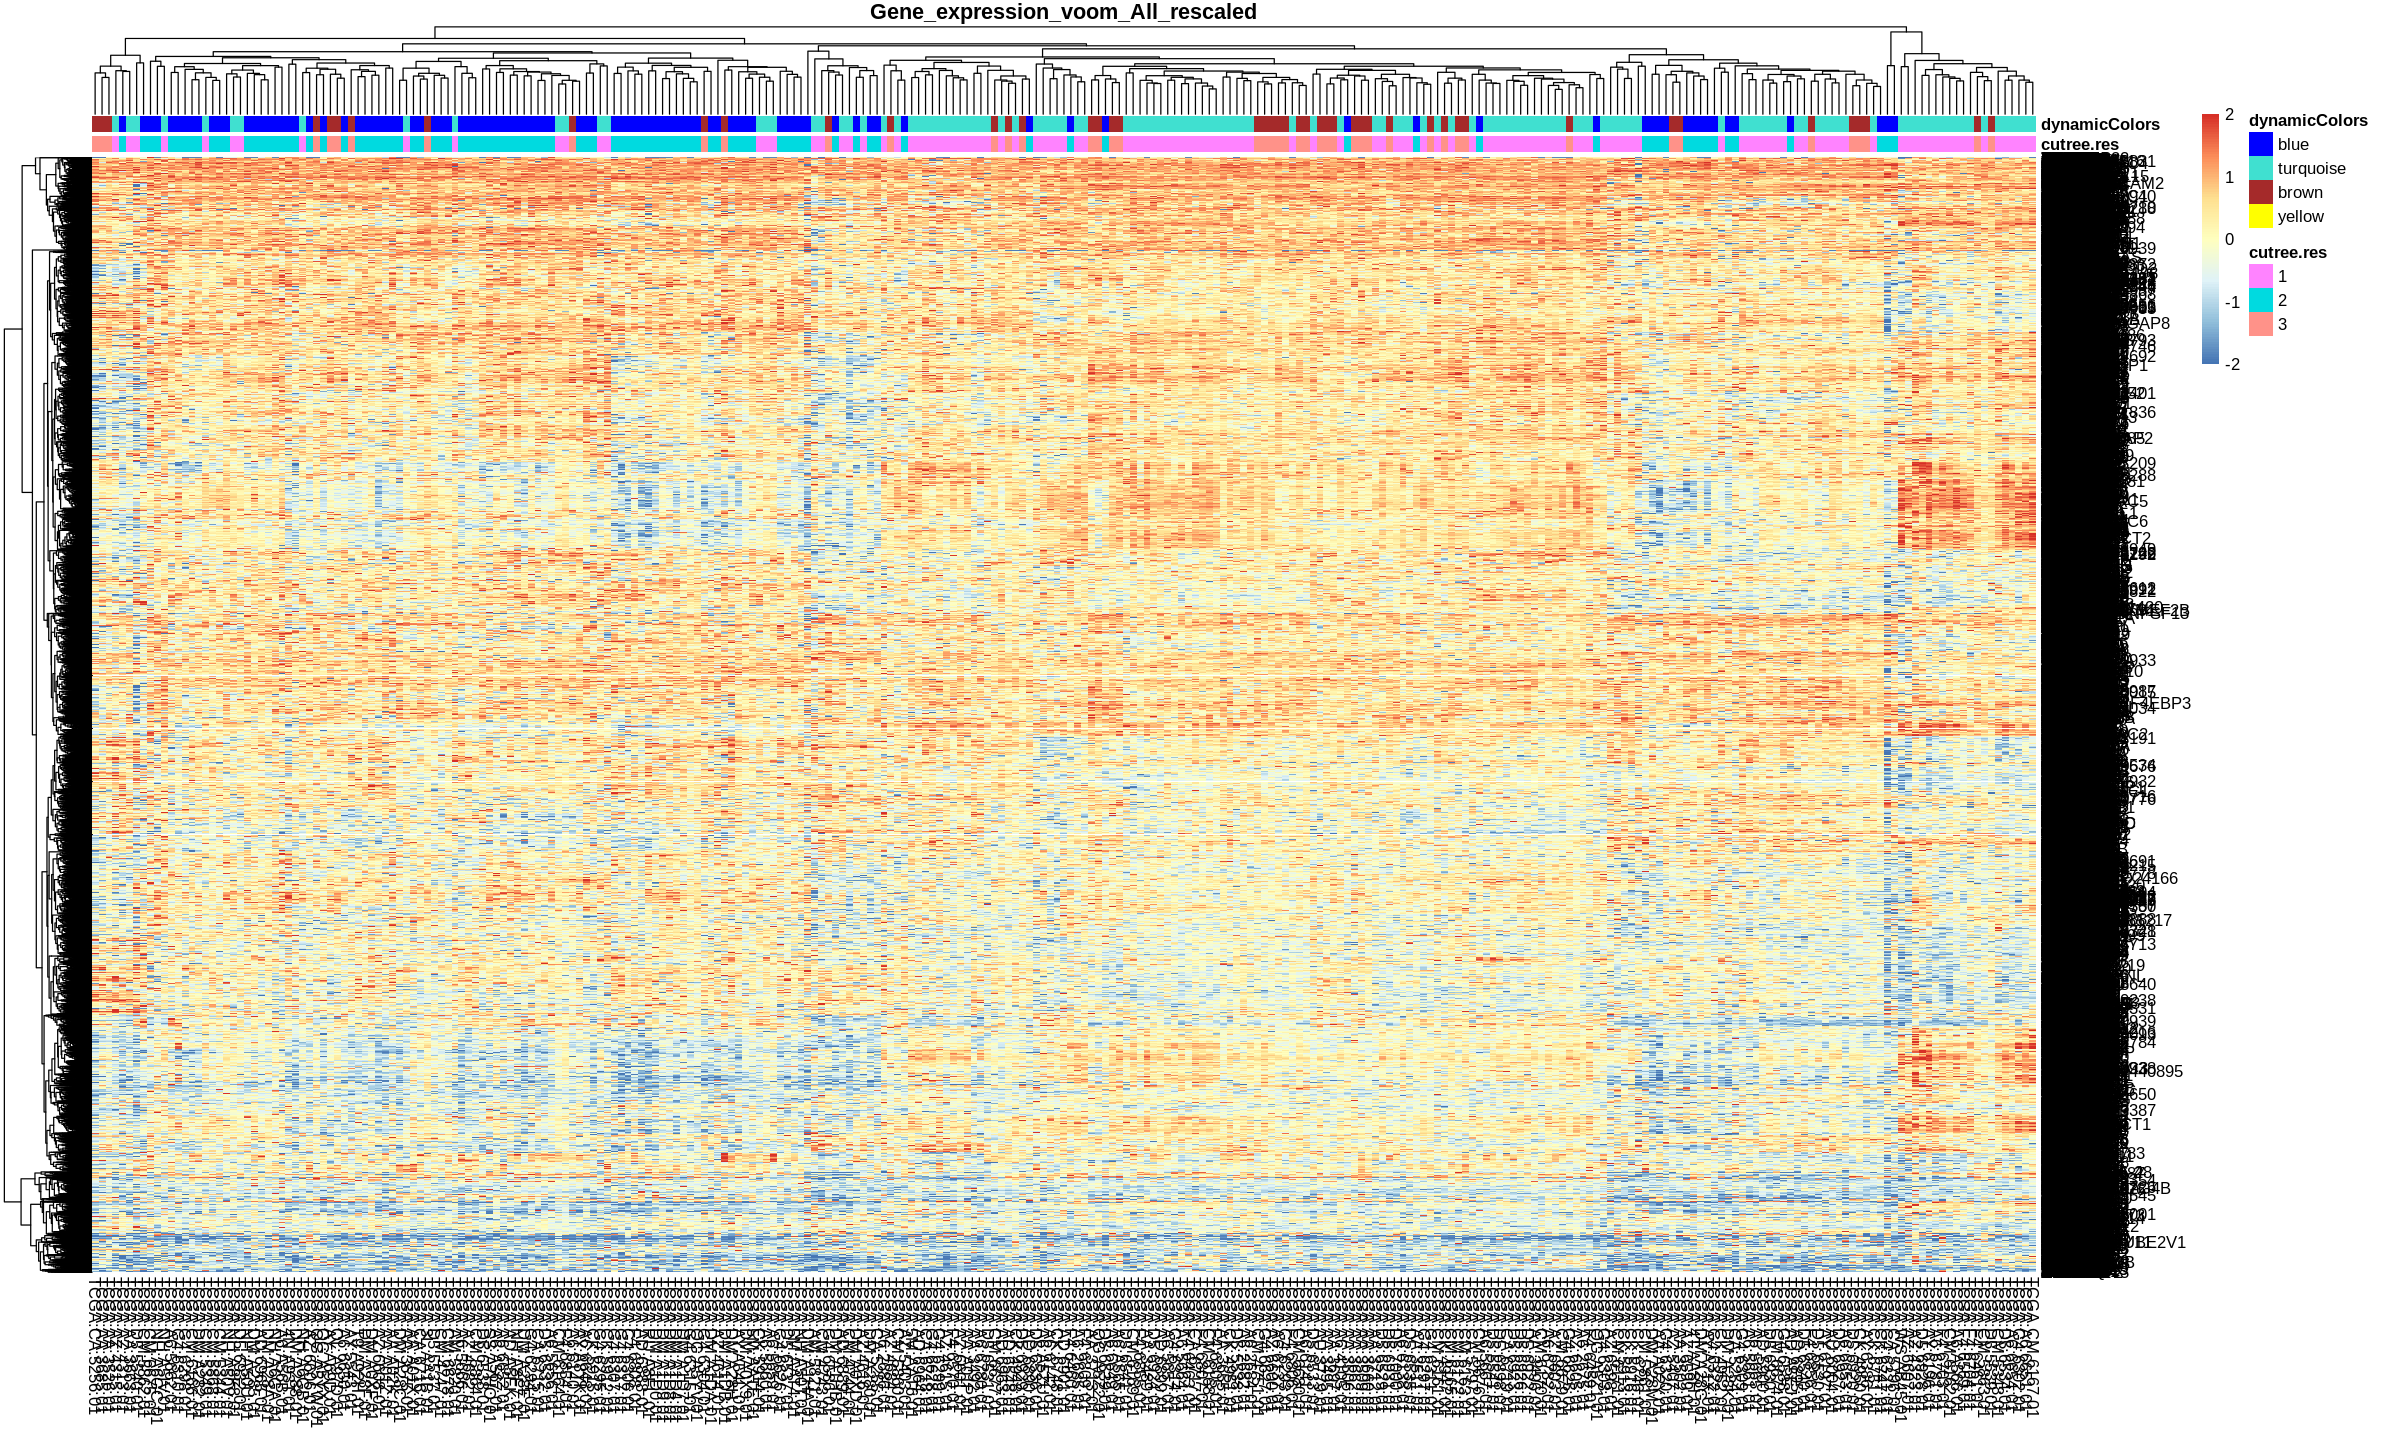

In [9]:
options(repr.plot.width=20, repr.plot.height=12)
pheatmap::pheatmap(vE.scaled,annotation_col = pData(COAD.ExpressionSet),
                   main = "Gene_expression_voom_All_rescaled",annotation_colors = ann_colors)